<h3>Importy

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

<h3> Inicjalizacja hiperparametrów i przygotowanie danych

In [ ]:
# Parametry
batch_size = 64
learning_rate = 0.01
epochs = 10
train_size = 0.8
out_channels = 16
kernel_size = 3
pool_size = 2
noise_std_dev = 0.2

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Transformacje danych (normalizacja)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Wczytanie FashionMNIST
train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)

# Podział na zbiór treningowy i walidacyjny
train_len = int(train_size * len(train_dataset))
val_len = len(train_dataset) - train_len
train_dataset, val_dataset = random_split(train_dataset, [train_len, val_len])

# Dataloader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


<h3> Definiowanie modelu

In [ ]:
class CNNClassifier(nn.Module):
    def __init__(self, in_channels=1, out_channels=16, kernel_size=3, pool_size=2, num_classes=10):
        super(CNNClassifier, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=1)   # warstwa CNN
        self.pool = nn.MaxPool2d(kernel_size=pool_size)                                         # operator MaxPool
        self.flatten = nn.Flatten()
        self.fc = nn.LazyLinear(num_classes)                                                    # warstwa liniowa

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x


<h3> Funkcja pomocnicza (szum gaussowski)

In [ ]:
def add_gaussian_noise(data, std_dev=0.1):
    noise = torch.normal(0, std_dev, size=data.shape).to(data.device)
    return data + noise

<h3> Funkcje pętli treningowej & ewlauacji wyników

In [7]:
def train_model(model, optimizer, criterion, train_loader, val_loader, device, noise_std=0.0):
    model.train()
    for epoch in range(epochs):
        train_loss, train_acc = 0, 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Dodanie szumu, jeśli wymagane
            if noise_std > 0.0:
                inputs = add_gaussian_noise(inputs, std_dev=noise_std)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            train_acc += (preds == labels).sum().item()
        
        val_loss, val_acc = evaluate_model(model, val_loader, criterion, device)
        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss/len(train_loader):.4f} | "
              f"Train Acc: {train_acc/len(train_loader.dataset):.4f} | "
              f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
        
def evaluate_model(model, loader, criterion, device):
    model.eval()
    loss, correct = 0, 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss += criterion(outputs, labels).item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
    return loss / len(loader), correct / len(loader.dataset)

<h3> Trening i testowanie

In [ ]:
# Model, optymalizator i funkcja kosztu
model = CNNClassifier(out_channels=out_channels, kernel_size=kernel_size, pool_size=pool_size).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

# Trening
train_model(model, optimizer, criterion, train_loader, val_loader, device, noise_std=noise_std_dev)

# Testowanie
test_loss, test_acc = evaluate_model(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}")


Epoch 1/10 | Train Loss: 0.7020 | Train Acc: 0.7517 | Val Loss: 0.6596 | Val Acc: 0.7549
Epoch 2/10 | Train Loss: 0.5152 | Train Acc: 0.8145 | Val Loss: 0.4605 | Val Acc: 0.8398
Epoch 3/10 | Train Loss: 0.4692 | Train Acc: 0.8331 | Val Loss: 0.4749 | Val Acc: 0.8228
Epoch 4/10 | Train Loss: 0.4419 | Train Acc: 0.8428 | Val Loss: 0.4202 | Val Acc: 0.8528
Epoch 5/10 | Train Loss: 0.4214 | Train Acc: 0.8502 | Val Loss: 0.4067 | Val Acc: 0.8589
Epoch 6/10 | Train Loss: 0.4066 | Train Acc: 0.8561 | Val Loss: 0.4006 | Val Acc: 0.8588
Epoch 7/10 | Train Loss: 0.3972 | Train Acc: 0.8596 | Val Loss: 0.3889 | Val Acc: 0.8636
Epoch 8/10 | Train Loss: 0.3857 | Train Acc: 0.8633 | Val Loss: 0.3683 | Val Acc: 0.8718
Epoch 9/10 | Train Loss: 0.3765 | Train Acc: 0.8664 | Val Loss: 0.3659 | Val Acc: 0.8715
Epoch 10/10 | Train Loss: 0.3689 | Train Acc: 0.8689 | Val Loss: 0.3693 | Val Acc: 0.8721
Test Loss: 0.3923 | Test Acc: 0.8650


<h3> Wizualizacja wyników

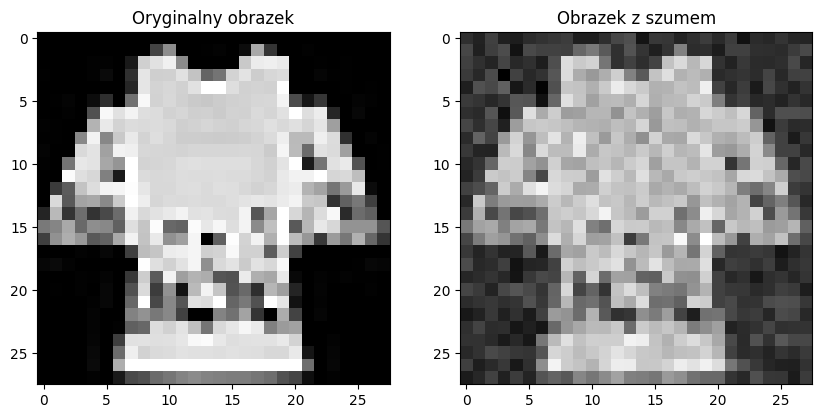

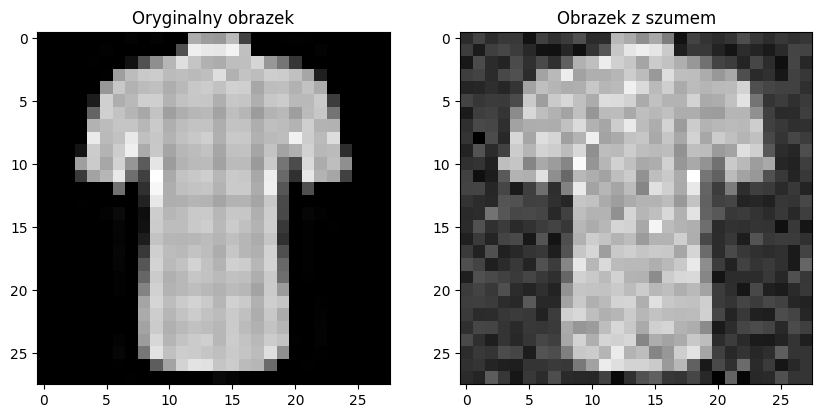

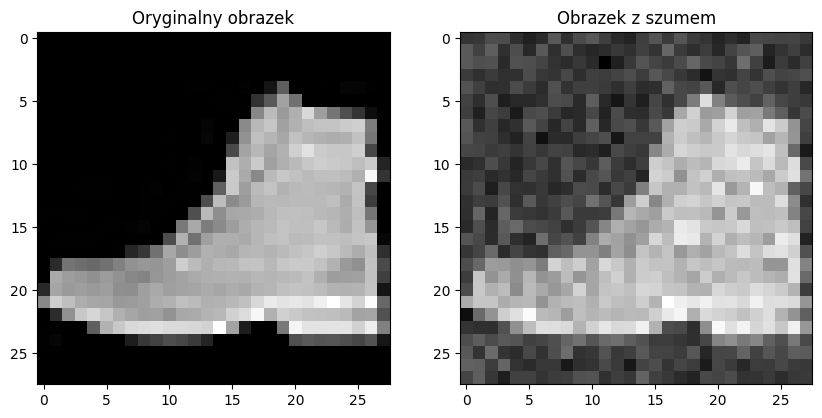

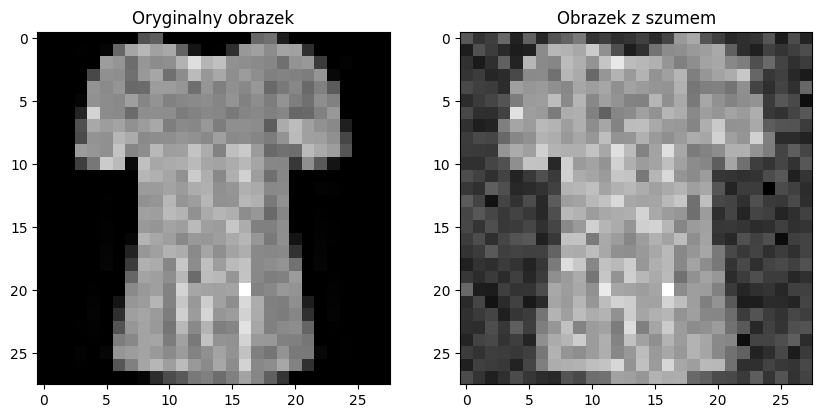

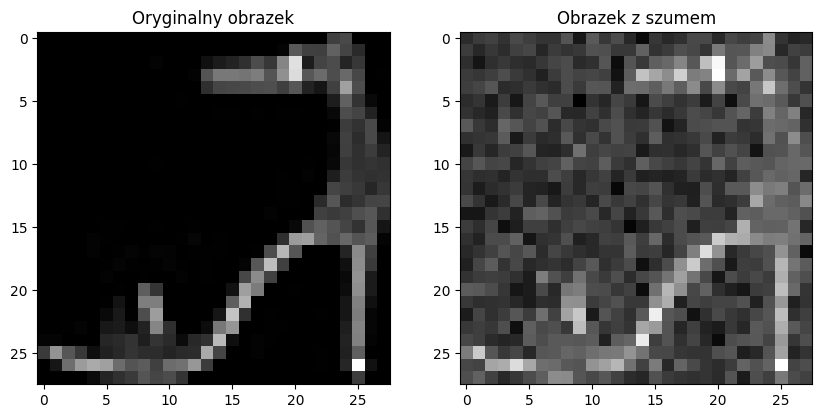

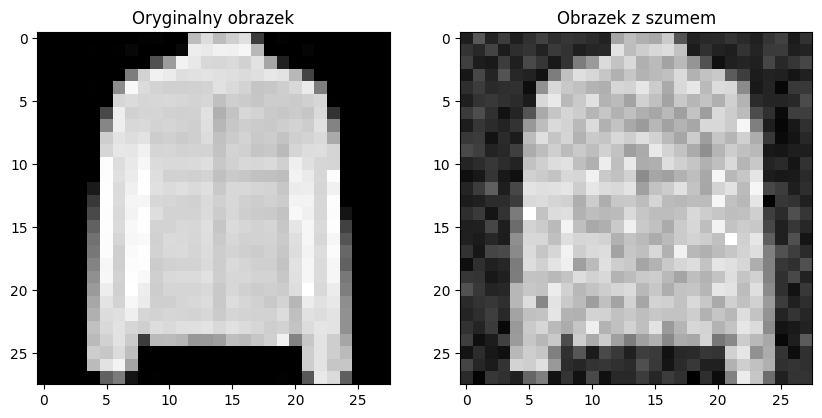

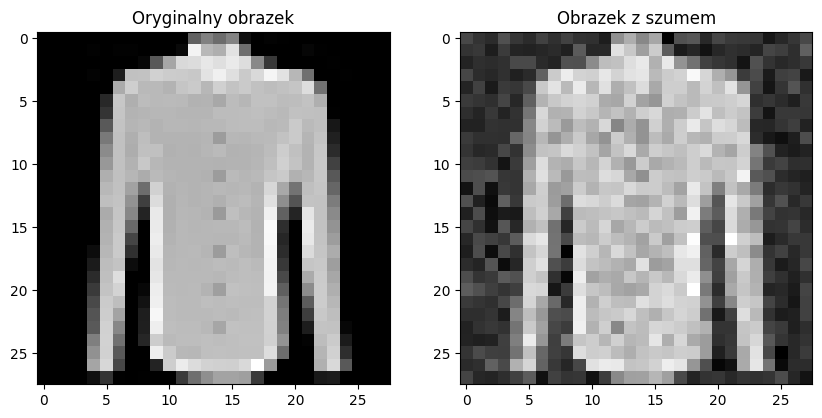

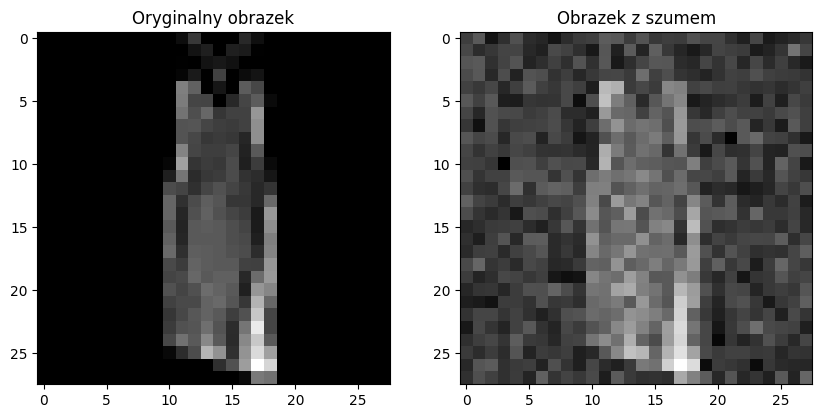

In [ ]:
for i in range(4):
    # Wizualizacja wpływu szumu na dane testowe
    examples = iter(test_loader)
    inputs, labels = next(examples)

    # Dodanie szumu
    inputs_noisy = add_gaussian_noise(inputs, std_dev=noise_std_dev)

    # Wizualizacja
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(inputs[0][0].cpu(), cmap='gray')
    axes[0].set_title("Oryginalny obrazek")
    axes[1].imshow(inputs_noisy[0][0].cpu(), cmap='gray')
    axes[1].set_title(f"Obrazek z szumem")
    plt.show()